In [3]:
import numpy as np
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

data = pd.read_csv('train.csv')

In [4]:
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (data.label == 1).sum(),
    (data.label == 0).sum()
))

Hatred labeled: 2242
Non-hatred labeled: 29720


In [5]:
hashtags = data['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
data.loc[:, 'hashtags'] = hashtags['hashtag']
data['hashtags'].fillna('', inplace=True)

data.loc[:, 'mentions'] = data['tweet'].str.count('@[a-zA-Z0-9_]+')

data.tweet = data.tweet.str.replace('@[a-zA-Z0-9_]+', '')

In [6]:
data.tweet = data.tweet.str.replace('[^a-zA-Z]', ' ')

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, FreqDist, word_tokenize

stemmer = SnowballStemmer('english')
lemmer = WordNetLemmatizer()

part = {
    'N' : 'n',
    'V' : 'v',
    'J' : 'a',
    'S' : 's',
    'R' : 'r'
}

def convert_tag(penn_tag):
    if penn_tag in part.keys():
        return part[penn_tag]
    else:
        return 'n'


def tag_and_lem(element):
    sent = pos_tag(word_tokenize(element))
    return ' '.join([lemmer.lemmatize(sent[k][0], convert_tag(sent[k][1][0]))
                    for k in range(len(sent))])
    

data.loc[:, 'tweet'] = data['tweet'].apply(lambda x: tag_and_lem(x))
data.loc[:, 'hashtags'] = data['hashtags'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

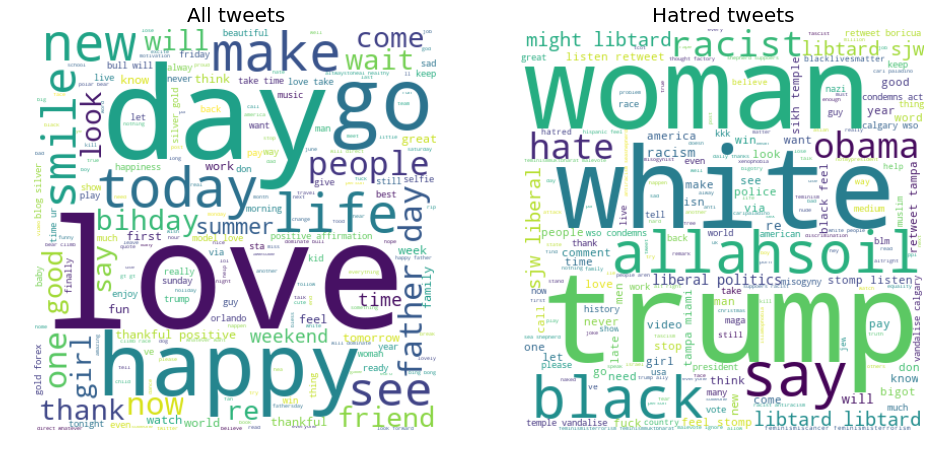

In [8]:
from wordcloud import WordCloud, STOPWORDS
stopwords = STOPWORDS.add('amp')

all_words = ' '.join(data.tweet.values)
hatred_words = ' '.join(data[data.label == 1].tweet.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(all_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('All tweets', size=20)

cloud2 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()

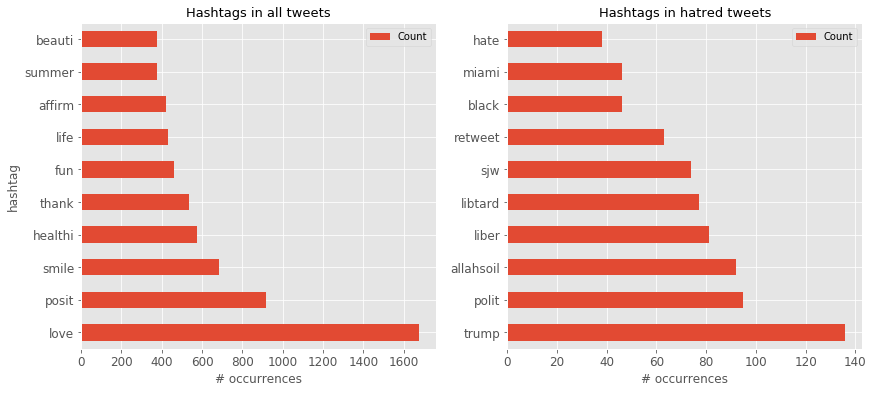

In [9]:
all_hashtags = FreqDist(list(' '.join(data.hashtags.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(data[data.label==1].hashtags.values).split())).most_common(10)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()

In [10]:
print("Number of mentions: {}\nNumber of tweets having a mention: {}\nCorrelation with label: {}".format(
    data.mentions.sum(),
    len(data[data.mentions > 0]),
    np.corrcoef(data.mentions, data.label)[0][1]
))

Number of mentions: 17571
Number of tweets having a mention: 11126
Correlation with label: 0.07851491623991753


In [11]:
data.drop('mentions', axis=1, inplace=True)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), min_df=10)
features = vectorizer.fit_transform(data.tweet)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(features, data.label)

Best parameters found were {'C': 30, 'penalty': 'l2'} with F1 score of 0.64


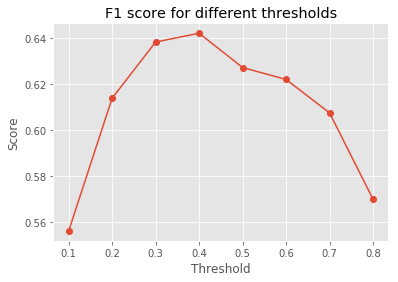

In [14]:
params = {'penalty': ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}
lrmodel = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=150), param_grid=params, scoring='f1', cv=5, n_jobs=-1)
lrmodel.fit(X_train, y_train)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    lrmodel.best_params_,
    lrmodel.best_score_
))
probas = lrmodel.predict_proba(X_test)
thresholds = np.arange(0.1, 0.9, 0.1)
scores = [f1_score(y_test, (probas[:, 1] >= x).astype(int)) for x in thresholds]
plt.plot(thresholds, scores, 'o-')
plt.title("F1 score for different thresholds")
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.show()

In [15]:
params = {'C': [1000, 3000, 9000, 15000]}
svc = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid=params, scoring='f1', cv=3, n_jobs=-1)
svc.fit(X_train, y_train)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    svc.best_params_,
    svc.best_score_
))
predictions = svc.predict(X_test)
print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_test, predictions)))

Best parameters found were {'C': 9000} with F1 score of 0.63

F1 test score for SVC: 0.63
